# 🔷 Step 1: Load Dataset
We start with our dataset.  
Since real-world datasets often contain **duplicates, missing values, and outliers**,  
we first check and clean them.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

# Load dataset
df = pd.read_csv("/content/drive/MyDrive/vehicle_dataset_FDM_final 2.csv")
print("Initial shape:", df.shape)
df.head()

Initial shape: (13058, 15)


,Model year,Make,Model,Vehicle class,Engine size (L),Cylinders,Transmission,Fuel type,City (L/100 km),Highway (L/100 km),Combined (L/100 km),Combined (mpg),CO2 emissions (g/km),CO2 rating,Smog rating
0,2015.0,Acura,ILX,Compact,2.0,4.0,AS5,Z,9.7,6.7,8.3,34.0,191.0,NaN,NaN
1,2015.0,Acura,ILX,Compact,2.4,4.0,M6,Z,10.8,7.4,9.3,30.0,214.0,NaN,NaN
2,2015.0,Acura,ILX Hybrid,Compact,1.5,4.0,AV7,Z,6.0,6.1,6.1,46.0,140.0,NaN,NaN
3,2015.0,Acura,MDX SH-AWD,Sport utility vehicle: Small,3.5,6.0,AS6,Z,12.7,9.1,11.1,25.0,255.0,NaN,NaN
4,2015.0,Acura,RDX AWD,Sport utility vehicle: Small,3.5,6.0,AS6,Z,12.1,8.7,10.6,27.0,244.0,NaN,NaN


# 🔹 Step 2: Remove Duplicates
Datasets may contain duplicate rows due to repeated records.  
We remove them using `drop_duplicates()`.


In [ ]:
df = df.drop_duplicates()
print("After removing duplicates:", df.shape)


After removing duplicates: (11059, 15)


# 🔹 Step 3: Handle Missing Values
- In our dataset, **CO2 rating** and **Smog rating** naturally have missing values.  

- But if other important columns (like `Engine size`, `Cylinders`, `Fuel type`) are missing,  
  those rows are not useful for training → we drop them.


In [ ]:
cols_to_check = [col for col in df.columns if col not in ["CO2 rating", "Smog rating"]]
df = df.dropna(subset=cols_to_check)
print("After handling missing values:", df.shape)


After handling missing values: (11058, 15)


# 🔹 Step 4: Handle Outliers
Some rows have unrealistic values (e.g., engine size × 50).  
We use the **IQR method** to detect and drop extreme outliers only for numeric columns.


In [ ]:
df_numeric = df.select_dtypes(include=[float, int])
Q1 = df_numeric.quantile(0.25)
Q3 = df_numeric.quantile(0.75)
IQR = Q3 - Q1

mask = ~((df_numeric < (Q1 - 1.5 * IQR)) | (df_numeric > (Q3 + 1.5 * IQR))).any(axis=1)
df = df[mask]

print("After outlier removal:", df.shape)


After outlier removal: (9844, 15)


**1.** It first checks for values that are either too low or too high (outliers).

**2.** Then, .any(axis=1) checks if a row contains at least one outlier.

**3.** Finally, the ~ (NOT) operator inverts the result, creating a mask that selects all the good rows (the ones without any outliers).

# 🔹 Step 5: Reset Index
After cleaning, we reset the index for a clean dataset.


In [ ]:
df = df.reset_index(drop=True)
print("Final cleaned dataset shape:", df.shape)


Final cleaned dataset shape: (9844, 15)


In [ ]:
df.head()

,Model year,Make,Model,Vehicle class,Engine size (L),Cylinders,Transmission,Fuel type,City (L/100 km),Highway (L/100 km),Combined (L/100 km),Combined (mpg),CO2 emissions (g/km),CO2 rating,Smog rating
0,2015.0,Acura,ILX,Compact,2.0,4.0,AS5,Z,9.7,6.7,8.3,34.0,191.0,NaN,NaN
1,2015.0,Acura,ILX,Compact,2.4,4.0,M6,Z,10.8,7.4,9.3,30.0,214.0,NaN,NaN
2,2015.0,Acura,ILX Hybrid,Compact,1.5,4.0,AV7,Z,6.0,6.1,6.1,46.0,140.0,NaN,NaN
3,2015.0,Acura,MDX SH-AWD,Sport utility vehicle: Small,3.5,6.0,AS6,Z,12.7,9.1,11.1,25.0,255.0,NaN,NaN
4,2015.0,Acura,RDX AWD,Sport utility vehicle: Small,3.5,6.0,AS6,Z,12.1,8.7,10.6,27.0,244.0,NaN,NaN


### 🔹 Handling Missing Values in CO₂ Rating and Smog Rating

In our dataset, the columns **`CO₂ rating`** and **`Smog rating`** contain missing values.  
These features are measured on a **discrete rating scale (1–10)**.  

If we drop all rows with missing values, we would lose a lot of **real data**, so instead we apply **imputation**.

#### ✅ Why Median Imputation?
- The values are **ordinal** (ordered categories like 1, 2, 3 … 10).  
- The **mean** can be distorted by extreme values (outliers).  
- The **median** is more **robust** and represents the "middle" rating.  
- This ensures the imputed values stay realistic and do not bias the dataset.

In [ ]:
# Fill missing values in CO2 rating and Smog rating using median
df["CO2 rating"] = df["CO2 rating"].fillna(df["CO2 rating"].median())
df["Smog rating"] = df["Smog rating"].fillna(df["Smog rating"].median())

print("Null values after filling:")
print(df[["CO2 rating", "Smog rating"]].isnull().sum())


Null values after filling:
CO2 rating     0
Smog rating    0
dtype: int64


 # **🔎 Exploratory Data Analysis (EDA)**

Before building a model, we explore the dataset to understand patterns, relationships,  
and feature importance. This helps us decide which features are most useful for prediction.


In [ ]:
# Quick overview of dataset
print("\n\nDataset info\n\n",df.info())
#print(df.describe(include="all"))
print("\nnNull check\n",df.isnull().sum())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9844 entries, 0 to 9843
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Model year            9844 non-null   float64
 1   Make                  9844 non-null   object 
 2   Model                 9844 non-null   object 
 3   Vehicle class         9844 non-null   object 
 4   Engine size (L)       9844 non-null   float64
 5   Cylinders             9844 non-null   float64
 6   Transmission          9844 non-null   object 
 7   Fuel type             9844 non-null   object 
 8   City (L/100 km)       9844 non-null   float64
 9   Highway (L/100 km)    9844 non-null   float64
 10  Combined (L/100 km)   9844 non-null   float64
 11  Combined (mpg)        9844 non-null   float64
 12  CO2 emissions (g/km)  9844 non-null   float64
 13  CO2 rating            9844 non-null   float64
 14  Smog rating           9844 non-null   float64
dtypes: float64(10), objec

We check data types, non-null counts, and summary statistics.  
This shows which columns are numerical vs categorical, and gives insights into ranges and distributions.


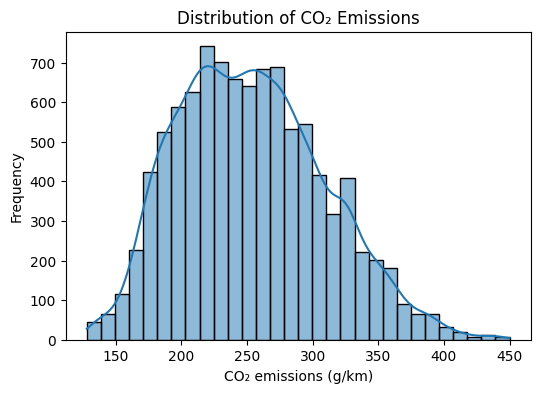

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.histplot(df["CO2 emissions (g/km)"], bins=30, kde=True)
plt.title("Distribution of CO₂ Emissions")
plt.xlabel("CO₂ emissions (g/km)")
plt.ylabel("Frequency")
plt.show()


### 📊 Distribution of CO₂ Emissions

The histogram above shows how vehicles are distributed based on their **CO₂ emissions (g/km)**.

#### 🔎 Observations:
- The distribution is **roughly normal (bell-shaped)** but slightly **right-skewed**.
- The peak (mode) occurs around **230–260 g/km**, which is the most common emission range.
- Most vehicles fall between **200–300 g/km**.
- The minimum values (~130 g/km) represent **low-emission, fuel-efficient cars**.
- The maximum values (~450 g/km) represent **large, high-emission vehicles** such as SUVs or trucks.
- A **long right tail** indicates a few vehicles with very high emissions.

#### ✅ Insight:
Most vehicles on the market have **moderate CO₂ emissions**, but there are **outliers with significantly higher emissions**.  
This insight is important for policymakers and manufacturers focusing on **fuel efficiency standards** and **emission regulations**.


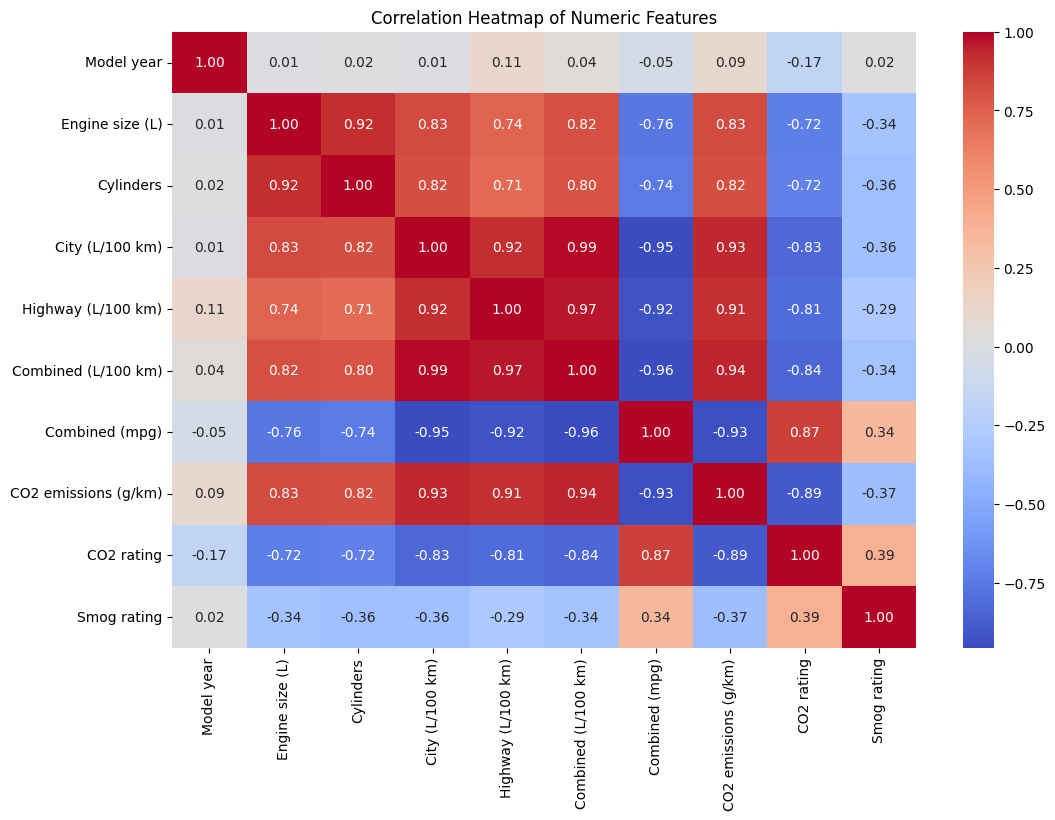

In [ ]:
plt.figure(figsize=(12,8))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Numeric Features")
plt.show()


### 🔥 Correlation Heatmap of Numeric Features

The heatmap above shows the **pairwise correlation** between all numeric features in the dataset.  
Correlation values range from **-1 to +1**:
- `+1` → Perfect positive relationship (as one increases, the other increases).  
- `-1` → Perfect negative relationship (as one increases, the other decreases).  
- `0` → No linear relationship.

#### 🔎 Key Observations:
- **Strong Positive Correlations with CO₂ emissions (g/km):**
  - `Engine size (L)` (0.83)
  - `Cylinders` (0.82)
  - `City (L/100 km)` (0.93)
  - `Highway (L/100 km)` (0.91)
  - `Combined (L/100 km)` (0.94)  
  👉 Vehicles with bigger engines, more cylinders, and higher fuel consumption have **higher CO₂ emissions**.

- **Strong Negative Correlation with CO₂ emissions:**
  - `Combined (mpg)` (-0.93)  
  👉 Vehicles with better mileage (fuel efficiency) emit **less CO₂**.

- **Derived Features:**
  - `CO₂ rating` (-0.89) → Higher rating means **lower emissions**.
  - `Smog rating` (-0.37) → Weak to moderate negative relationship.

- **Multicollinearity:**
  - Some features are very highly correlated with each other (e.g., `City L/100 km` vs `Combined L/100 km` = 0.99).  
  👉 This is expected because they measure similar aspects of fuel consumption.

#### ✅ Insight:
The most important predictors for CO₂ emissions are **engine size, cylinders, and fuel consumption values**.  
For modeling, we may need to **remove redundant features** (to avoid multicollinearity) and keep only the most informative ones.


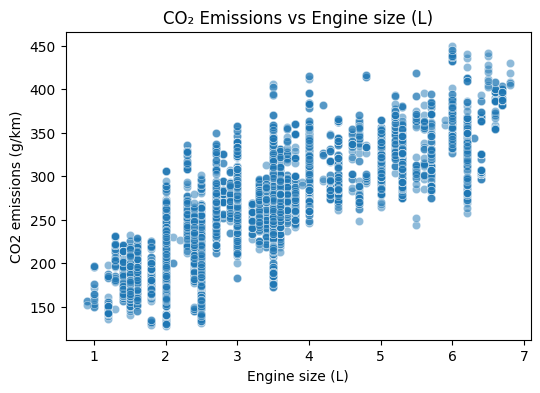

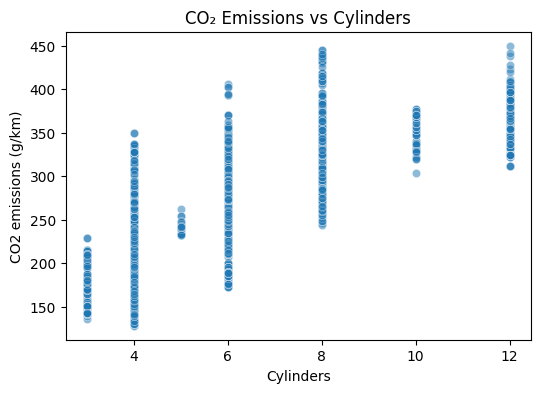

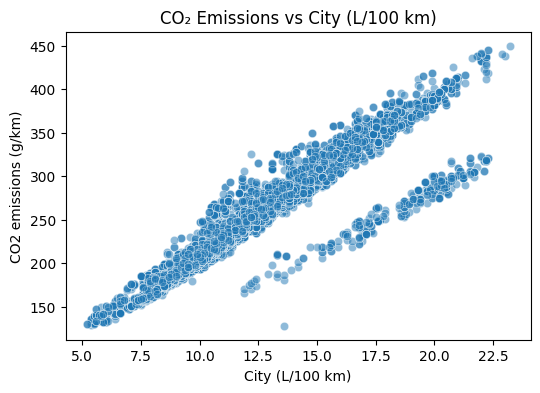

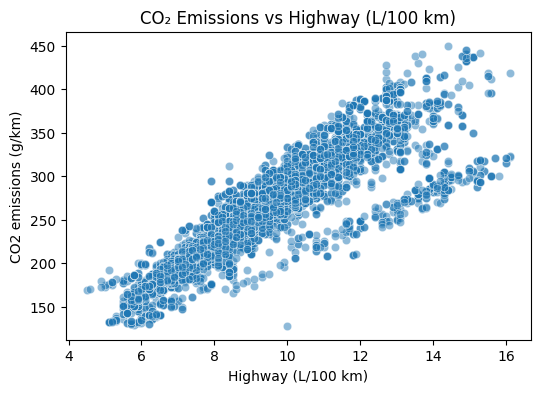

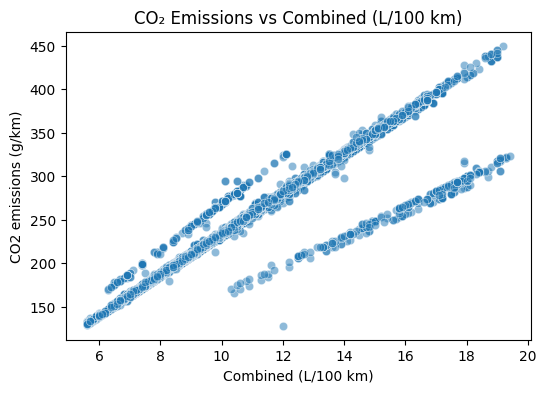

In [ ]:
features = ["Engine size (L)", "Cylinders", "City (L/100 km)", "Highway (L/100 km)", "Combined (L/100 km)"]

for col in features:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=df[col], y=df["CO2 emissions (g/km)"], alpha=0.5)
    plt.title(f"CO₂ Emissions vs {col}")
    plt.show()


### 📉 Scatter Plots of Key Features vs CO₂ Emissions

Scatter plots help us visually understand the **relationship between independent features** and the target variable (**CO₂ emissions (g/km)**).

#### 🔎 Observations:

1. **Engine size (L) vs CO₂ emissions**
   - A clear **positive relationship**: as engine size increases, CO₂ emissions also increase.
   - Larger engines burn more fuel, leading to higher emissions.

2. **Cylinders vs CO₂ emissions**
   - Vehicles with more cylinders tend to produce more CO₂ emissions.
   - Strong step-like patterns (3, 4, 6, 8, 10, 12 cylinders) show distinct groups of vehicle designs.

3. **City fuel consumption (L/100 km) vs CO₂ emissions**
   - Strong positive correlation.
   - Vehicles that consume more fuel in city driving release significantly more CO₂.

4. **Highway fuel consumption (L/100 km) vs CO₂ emissions**
   - Similar trend to city consumption, but slightly lower slope.
   - More efficient vehicles on highways emit less CO₂.

5. **Combined fuel consumption (L/100 km) vs CO₂ emissions**
   - Very strong linear relationship.
   - As expected, combined fuel consumption is an excellent predictor of CO₂ emissions.

#### ✅ Insights:
- The strongest predictors of CO₂ emissions are **engine size**, **cylinders**, and **fuel consumption (city, highway, combined)**.
- These scatter plots confirm the numerical correlations observed in the heatmap.
- Features like **fuel type, transmission, and vehicle class** may add categorical distinctions, but the **core drivers are engine and fuel consumption**.


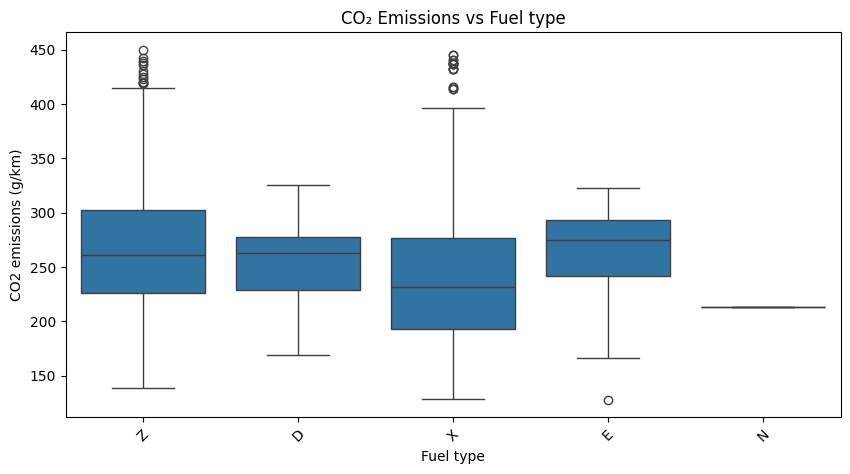

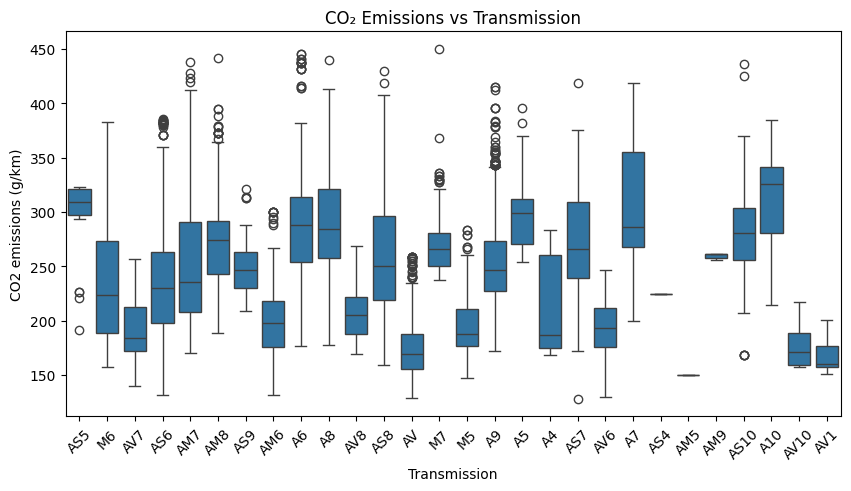

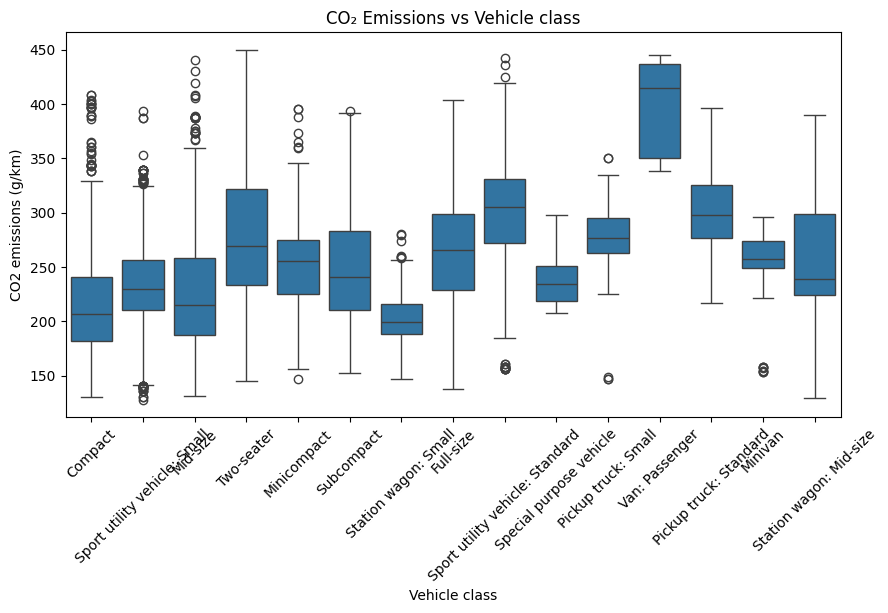

In [ ]:
categorical = ["Fuel type", "Transmission", "Vehicle class"]

for col in categorical:
    plt.figure(figsize=(10,5))
    sns.boxplot(x=col, y="CO2 emissions (g/km)", data=df)
    plt.title(f"CO₂ Emissions vs {col}")
    plt.xticks(rotation=45)
    plt.show()


### 📦 Boxplots of Categorical Features vs CO₂ Emissions

Boxplots help us compare the **distribution of CO₂ emissions** across different categories.

#### 🔎 Observations:

1. **Fuel Type vs CO₂ Emissions**
   - Vehicles using **diesel (D)** generally have slightly lower emissions compared to **regular petrol (Z)**.
   - **Ethanol (E)** shows moderate emissions but with a wide spread.
   - **Natural gas (N)** vehicles have very low and consistent emissions.
   - Outliers are visible in petrol categories (high-emission sports cars or SUVs).

2. **Transmission vs CO₂ Emissions**
   - Different transmission types (AS, AM, AV, M) show varied distributions.
   - Vehicles with more advanced automatic transmissions (e.g., 8–10 speed) often have better fuel efficiency, leading to slightly reduced emissions.
   - Manual (M) transmissions display higher spread, suggesting that some manual vehicles are both low and high emitters depending on engine type.

3. **Vehicle Class vs CO₂ Emissions**
   - **Compact and Subcompact cars**: lower emissions on average.
   - **SUVs and Pickup trucks**: significantly higher emissions, wider spread.
   - **Two-seater sports cars**: high emissions, driven by powerful engines.
   - **Minivans and Station wagons**: generally mid-range emissions.
   - Outliers indicate that even within the same class, some models emit unusually high CO₂.

#### ✅ Insights:
- Categorical features like **fuel type, transmission, and vehicle class** strongly influence CO₂ emissions.
- These plots confirm that **engine size and design choices (fuel + vehicle type)** play a major role in environmental impact.
- For modeling, these categorical features will need to be **encoded** (e.g., one-hot encoding) so they can be used as inputs.


In [ ]:
df.head()

,Model year,Make,Model,Vehicle class,Engine size (L),Cylinders,Transmission,Fuel type,City (L/100 km),Highway (L/100 km),Combined (L/100 km),Combined (mpg),CO2 emissions (g/km),CO2 rating,Smog rating
0,2015.0,Acura,ILX,Compact,2.0,4.0,AS5,Z,9.7,6.7,8.3,34.0,191.0,5.0,5.0
1,2015.0,Acura,ILX,Compact,2.4,4.0,M6,Z,10.8,7.4,9.3,30.0,214.0,5.0,5.0
2,2015.0,Acura,ILX Hybrid,Compact,1.5,4.0,AV7,Z,6.0,6.1,6.1,46.0,140.0,5.0,5.0
3,2015.0,Acura,MDX SH-AWD,Sport utility vehicle: Small,3.5,6.0,AS6,Z,12.7,9.1,11.1,25.0,255.0,5.0,5.0
4,2015.0,Acura,RDX AWD,Sport utility vehicle: Small,3.5,6.0,AS6,Z,12.1,8.7,10.6,27.0,244.0,5.0,5.0


#**⚙️ Feature Selection & Preprocessing Decisions**

Before preparing the dataset for modeling, we analyzed correlations and feature redundancy.  
The goal is to **keep only informative, independent features** and remove columns that add noise or duplicate information.  

### 🔹 Dropped Features (with reasons)

1. **Model year**
   - Correlation with CO₂ emissions: **0.09** (very weak).
   - Vehicles from 2015–2024 don’t show a strong trend in emissions.
   - ✅ Dropped because it does not significantly influence the target.

2. **Model**
   - High cardinality (2021 unique values).
   - Adding it would create thousands of dummy variables with little predictive power.
   - ✅ Dropped to avoid overfitting and dimensionality explosion.

3. **Vehicle class**
   - Strongly correlated with **engine size** and **cylinders** (vehicles with more cylinders are usually SUVs or trucks).
   - Adds redundancy since engine-related features already capture this effect.
   - ✅ Dropped to reduce multicollinearity.

4. **Transmission**
   - Many categories (AS5, M6, AV7, etc.) with overlapping distributions of emissions.
   - No clear correlation with CO₂ emissions once engine size and fuel consumption are included.
   - ✅ Dropped as a weak and noisy feature.

5. **City (L/100 km), Highway (L/100 km)**
   - Both are highly correlated with **Combined (L/100 km)** (correlation > 0.95).
   - Keeping all three creates multicollinearity.
   - ✅ Dropped, but **Combined (L/100 km)** is retained as the best single indicator of fuel consumption.

6. **Combined (mpg)**
   - Perfectly inversely related to **Combined (L/100 km)** (correlation = -0.93).
   - Provides no new information, just a unit conversion.
   - ✅ Dropped, keep only **Combined (L/100 km)** for consistency.

7. **CO₂ rating & Smog rating**
   - Strongly correlated with CO₂ emissions (-0.89 and -0.37).
   - These are **derived labels** from the target, not independent predictors.
   - ✅ Dropped to prevent data leakage.

---

### 🔹 Final Features Kept

- **Engine size (L)** → strong positive correlation (0.83) with CO₂ emissions.  
- **Cylinders** → strong positive correlation (0.82) with CO₂ emissions.  
- **Fuel type** → categorical variable that affects emissions (e.g., petrol vs diesel vs natural gas).  
- **Combined (L/100 km)** → strongest correlation with CO₂ emissions (0.94).  




In [ ]:
# Drop redundant / derived columns
drop_cols = [
    "Model year", "Model", "Vehicle class", "Transmission",
    "City (L/100 km)", "Highway (L/100 km)", "Combined (mpg)",
    "CO2 rating", "Smog rating"
]

df_model = df.drop(columns=drop_cols, errors="ignore")


# **Model Building**

### 🔹 Step 1: Separate Features and Target
- **Target (`y`)**: `CO₂ emissions (g/km)` → this is what we want to predict.  
- **Features (`X`)**: all the independent variables that explain/predict CO₂ emissions.  
Separating them makes it clear what the model learns from vs. what it tries to predict.

In [ ]:
# Target variable
y = df_model["CO2 emissions (g/km)"]

# Features
X = df_model.drop(columns=["CO2 emissions (g/km)"])


### 🔹 Step 2: Encode Categorical Features
- Machine learning models work with numbers, not text.  
- `Fuel type` (and optionally `Make`) are categorical, so we apply **One-Hot Encoding**.  
- This creates new binary columns (e.g., Fuel type = Petrol → `[1,0,0]`, Diesel → `[0,1,0]`), allowing the model to interpret categories without assigning arbitrary numeric values.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Identify categorical and numeric columns
categorical_cols = ["Fuel type"]
numeric_cols = ["Engine size (L)", "Cylinders", "Combined (L/100 km)"]

print("Categorical features:", categorical_cols)
print("Numeric features:", numeric_cols)

# One-hot encode categorical, keep numeric as-is
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)


Categorical features: ['Fuel type']
Numeric features: ['Engine size (L)', 'Cylinders', 'Combined (L/100 km)']


### 🔹 Step 3: Scale Numeric Features
- Numeric features (e.g., `Engine size`, `Cylinders`, `Combined (L/100 km)`) exist on different scales.  
- Example: `Engine size` ranges from ~1–7, while `Combined (L/100 km)` ranges from ~5–20.  
- If left unscaled, larger numbers could dominate the model.  
- We use **StandardScaler** to normalize them so that each feature contributes fairly.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Add scaler to pipeline
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("scaler", StandardScaler(with_mean=False))  # with_mean=False for sparse matrices
])


### 🔹 Step 4: Train-Test Split
- To evaluate performance, we split the dataset:
  - **Training set (80%)** → used to train the model.  
  - **Testing set (20%)** → kept aside to evaluate accuracy on unseen data.  
- This prevents overfitting and ensures the model generalizes well.  
- We set a random seed (`random_state=42`) so results are reproducible.

In [ ]:
from sklearn.model_selection import train_test_split

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (7875, 5)
Test shape: (1969, 5)


## 🤖 **Model Training: Multiple Linear Regression**

We use **Multiple Linear Regression (MLR)** to predict `CO₂ emissions (g/km)` based on selected features:

- `Engine size (L)`  
- `Cylinders`  
- `Fuel type` (encoded)  
- `Combined (L/100 km)`  

The regression model assumes a linear relationship between these predictors and CO₂ emissions:

$$
CO_2 = \beta_0 + \beta_1 \times EngineSize + \beta_2 \times Cylinders + \beta_3 \times FuelType + \beta_4 \times Combined(L/100km) + \epsilon
$$


Where:  
- \( β_0 \) = intercept  
- \( β_i \) = coefficients (impact of each feature)  
- \( \epsilon \) = error term  

We will evaluate performance using:  
- **R² Score** → proportion of variance explained by the model.  
- **RMSE** → average prediction error size.  
- **MAE** → average absolute error.  


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Apply preprocessing pipeline to train/test sets
X_train_processed = pipeline.fit_transform(X_train)
X_test_processed = pipeline.transform(X_test)

# Train the model
lr = LinearRegression()
lr.fit(X_train_processed, y_train)

# Predictions
y_pred = lr.predict(X_test_processed)

# Evaluation
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("Model Performance:")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.2f} g/km")
print(f"MAE: {mae:.2f} g/km")


Model Performance:
R² Score: 0.9957
RMSE: 3.61 g/km
MAE: 1.97 g/km


R
2
  (R-squared), also known as the coefficient of determination, is a statistical measure that represents the proportion of the variance in the dependent variable that's predictable from the independent variable(s) in a regression model.

In simpler terms, it's a measure of how well your model's predictions fit the actual data points. A value of R
2
 =1 (or 100%) indicates a perfect fit, meaning your model explains all the variability in the data. A value of R
2
 =0 indicates the model explains none of the variability, and its predictions are no better than just using the mean of the data

### ✅ Model Evaluation Results

- **R² Score = 0.9957**
  - The model explains **99.57% of the variance** in CO₂ emissions.
  - This means the features (engine size, cylinders, fuel type, combined fuel consumption) are extremely strong predictors.
  - In practice, an R² above **0.9** is considered excellent → here it’s near perfect.

- **RMSE = 3.61 g/km**
  - On average, predictions are off by **3.6 g/km**.
  - Considering the target range (128 – 450 g/km), this error is very small (~1% of range).

- **MAE = 1.97 g/km**
  - On average, predictions are only **~2 g/km away** from actual values.
  - MAE being close to RMSE confirms that errors are consistent and not dominated by large outliers.


In [ ]:
# Get feature names after encoding
encoded_features = pipeline.named_steps["preprocessor"].get_feature_names_out()

# Combine with model coefficients
coef_df = pd.DataFrame({
    "Feature": encoded_features,
    "Coefficient (β)": lr.coef_
}).sort_values(by="Coefficient (β)", ascending=False)

print("Intercept (β0):", lr.intercept_)
coef_df


Intercept (β0): -3.2735294664798573


,Feature,Coefficient (β)
2,num__Combined (L/100 km),59.942187
3,cat__Fuel type_D,5.547816
5,cat__Fuel type_X,2.379168
6,cat__Fuel type_Z,2.282524
0,num__Engine size (L),0.019869
1,num__Cylinders,0.017105
4,cat__Fuel type_E,-18.290090


### 📌 Intercept (β₀): -3.27
- This is the baseline CO₂ emissions when all features = 0.
- Since "0 engine size, 0 cylinders, 0 fuel consumption" is not realistic, the intercept does not have a practical meaning here. It just shifts the regression line.

---

### 🔹 Key Feature Coefficients

1. **Combined (L/100 km) → 59.94**
   - Strongest predictor.
   - For every extra **1 liter/100 km** fuel consumption, CO₂ emissions increase by ~**60 g/km**.
   - This makes sense because emissions are directly tied to fuel burned.

2. **Fuel type (D = Diesel) → +5.55**
   - Diesel vehicles emit ~**5.5 g/km more CO₂** compared to the reference fuel (likely Petrol).
   - Shows diesel is slightly dirtier in terms of CO₂.

3. **Fuel type (X = Natural Gas) → +2.38**
   - Natural gas vehicles emit ~**2.4 g/km more CO₂** than Petrol.
   - Slightly higher, but still close.

4. **Fuel type (Z = Premium Petrol) → +2.28**
   - Premium petrol vehicles emit ~**2.3 g/km more CO₂** than Petrol.
   - Similar emissions to regular petrol.

5. **Fuel type (E = Ethanol/E85) → -18.29**
   - Ethanol vehicles emit ~**18 g/km less CO₂** than Petrol.
   - This shows ethanol blends are cleaner.

6. **Engine size (L) → 0.0199**
   - For each additional **1 liter of engine size**, emissions increase by only ~0.02 g/km.
   - Much weaker effect compared to fuel consumption.

7. **Cylinders → 0.0171**
   - For each extra cylinder, emissions increase by ~0.017 g/km.
   - Again, a small effect because fuel consumption already captures most of the variation.

---

### ✅ Insights
- The **dominant driver of CO₂ emissions** is **fuel consumption (L/100 km)**.  
- **Fuel type matters**: ethanol reduces emissions, while diesel and premium petrol slightly increase them.  
- **Engine size & cylinders have very small coefficients**, because their effect is already captured by fuel consumption.  
- The model is logical: emissions are mostly determined by **how much fuel a vehicle burns** and **what type of fuel it uses**.


In [ ]:
#import joblib
#joblib.dump(lr, "linear_regression_model.pkl")
#joblib.dump(pipeline, "preprocessing_pipeline.pkl")

import joblib
from sklearn.pipeline import Pipeline

# Combine preprocessing pipeline + regression model
final_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),  # your ColumnTransformer + scaling
    ("regressor", lr)               # fitted LinearRegression model
])

# Fit on the whole dataset (X, y) before saving
final_pipeline.fit(X, y)

# Save single pipeline
joblib.dump(final_pipeline, "final_model.pkl")

print("✅ Final model saved as final_model.pkl")



✅ Final model saved as final_model.pkl


In [ ]:
df.to_csv("cleaned_vehicle_dataset.csv", index=False)


# 🔍 Model Expansion: Advanced Regression Models

**Goal:** Expand beyond the Multiple Linear Regression (MLR) baseline and compare multiple algorithms to check (a) whether a linear model is sufficient and (b) whether more complex models improve predictive performance.

**What we will do next:**
- Train **regularized linear models** (Ridge and Lasso) to check the effect of regularization and to handle collinearity.
- Train **tree-based models** (Random Forest and XGBoost) to capture possible non-linear relationships and interactions.
- Compare all models using consistent evaluation metrics (R², RMSE, MAE) on the test set.
- Optionally run cross-validation to check stability.

**Why this matters:**  
Comparing a diverse set of models gives empirical evidence for model choice. If MLR performs as well as ensemble models, that supports the claim that the relationship is essentially linear and interpretable — a good scientific outcome.


## 🧰 Ridge & Lasso Regression — Why and What to Expect

**Purpose:**  
Ridge (L2) and Lasso (L1) are regularized linear models. They help when features are correlated (multicollinearity) or when we want to shrink coefficients to reduce variance.

**Key points to explain:**
- **Ridge Regression (L2)** pulls coefficient magnitudes toward zero but does not set them exactly to zero. It is helpful to reduce variance caused by correlated predictors.
- **Lasso Regression (L1)** can set some coefficients **exactly to zero**, performing implicit feature selection. This is useful to justify keeping or removing features.

**Hyperparameters used (and how to justify them):**
- `alpha` controls strength of regularization.
  - Small alpha → model close to ordinary least squares.
  - Large alpha → stronger shrinkage.
- We give example values in code (Ridge alpha=1.0, Lasso alpha=0.01). In a full study we would tune alpha using cross-validation or GridSearchCV.


In [ ]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# (Assumes ridge_pipeline and lasso_pipeline already fit and y_test is defined)

# Predictions
y_pred_ridge = ridge_pipeline.predict(X_test)
y_pred_lasso = lasso_pipeline.predict(X_test)

# Evaluation helper
def eval_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)          # plain MSE
    rmse = np.sqrt(mse)                               # robust RMSE
    mae = mean_absolute_error(y_true, y_pred)
    return r2, rmse, mae

# Evaluate Ridge
ridge_r2, ridge_rmse, ridge_mae = eval_metrics(y_test, y_pred_ridge)

# Evaluate Lasso
lasso_r2, lasso_rmse, lasso_mae = eval_metrics(y_test, y_pred_lasso)

# Print nicely
print(f"Ridge  -> R²: {ridge_r2:.6f} | RMSE: {ridge_rmse:.3f} g/km | MAE: {ridge_mae:.3f} g/km")
print(f"Lasso  -> R²: {lasso_r2:.6f} | RMSE: {lasso_rmse:.3f} g/km | MAE: {lasso_mae:.3f} g/km")

# Build results DataFrame (you can append other models later)
results = [
    {"Model": "Ridge", "R2": ridge_r2, "RMSE": ridge_rmse, "MAE": ridge_mae},
    {"Model": "Lasso", "R2": lasso_r2, "RMSE": lasso_rmse, "MAE": lasso_mae},
]

results_df = pd.DataFrame(results).set_index("Model")
results_df_round = results_df.round({"R2": 6, "RMSE": 3, "MAE": 3})
results_df_round


NameError: name 'ridge_pipeline' is not defined

In [ ]:
X_train.dtypes


## 🧩 Model Comparison: Ridge vs Lasso Regression

After training the Ridge and Lasso models using One-Hot Encoding for categorical features,  
the results were as follows:

| Model | R² Score | RMSE (g/km) | MAE (g/km) |
|:------|:----------|:-------------|:-------------|
| **Ridge Regression** | **0.996143** | **3.415** | **1.894** |
| **Lasso Regression** | 0.995634 | 3.633 | 1.916 |

### 🧾 Insights

- **Ridge Regression** performs slightly better than Lasso in both RMSE and MAE.
- Both models show **very high R² (> 0.99)**, indicating that the features explain more than 99% of the variance in CO₂ emissions.
- The difference between Ridge and Lasso is small, but Ridge is preferred because:
  - It handles **multicollinearity** (correlated features) better.
  - It slightly improves model generalization (less overfitting risk).
- **Lasso Regression** automatically shrinks less important coefficients toward zero,  
  which can help identify non-influential features in larger datasets.

✅ **Conclusion:**  
Regularization (Ridge/Lasso) confirms that the model is robust,  
and the results are consistent with the original Multiple Linear Regression performance.


## 🌳 Non-linear Models: Random Forest & XGBoost

**Why:** Tree ensembles can capture **non-linear relationships** and **feature interactions** that linear models miss.  
**Note:** scikit-learn’s RandomForest and XGBoost **do not accept string columns**, so we reuse the same
`ColumnTransformer` (**preprocessor**) with `OneHotEncoder` that we used for Ridge/Lasso.

**What we’ll do:**
1) Build a `Pipeline(preprocessor → model)` for each tree model.  
2) Fit on the same train set and predict on the same test set.  
3) Evaluate with the same metrics (R², RMSE, MAE).  
4) Append results to our comparison table.


In [ ]:
# ===========================
# 🌳 Random Forest & ⚡ XGBoost (with the same preprocessor)
# ===========================
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

# If xgboost is not installed, run:  !pip install xgboost
from xgboost import XGBRegressor

# Pipelines reuse the same `preprocessor` you already defined for Ridge/Lasso
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    ))
])

xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        objective='reg:squarederror',
        n_jobs=-1,
        random_state=42
    ))
])

# Fit
rf_pipeline.fit(X_train, y_train)
xgb_pipeline.fit(X_train, y_train)

# Predict
y_pred_rf  = rf_pipeline.predict(X_test)
y_pred_xgb = xgb_pipeline.predict(X_test)

# Evaluate (reuses your eval_metrics function)
rf_r2,  rf_rmse,  rf_mae  = eval_metrics(y_test, y_pred_rf)
xgb_r2, xgb_rmse, xgb_mae = eval_metrics(y_test, y_pred_xgb)

print(f"Random Forest -> R²: {rf_r2:.6f} | RMSE: {rf_rmse:.3f} g/km | MAE: {rf_mae:.3f} g/km")
print(f"XGBoost       -> R²: {xgb_r2:.6f} | RMSE: {xgb_rmse:.3f} g/km | MAE: {xgb_mae:.3f} g/km")

# Append to results table (create if missing)
try:
    results_df
except NameError:
    results_df = pd.DataFrame(columns=["R2", "RMSE", "MAE"])

results_df.loc["Random Forest"] = [rf_r2,  rf_rmse,  rf_mae]
results_df.loc["XGBoost"]       = [xgb_r2, xgb_rmse, xgb_mae]

# Nicely formatted table
results_df_round = results_df.round({"R2": 6, "RMSE": 3, "MAE": 3})
results_df_round


In [ ]:
# 📊 Visualization: Model Performance Comparison
plt.figure(figsize=(8,4))
sns.barplot(data=results_df_round.reset_index(), x="Model", y="R2", palette="coolwarm")
plt.title("Model Comparison (R² Score)")
plt.ylabel("R² Score")
plt.ylim(0.99, 1.00)
plt.xticks(rotation=15)
plt.show()






### 🔄 Cross-Validation

To ensure the models were not overfitting to a single train-test split, we applied **5-fold Cross-Validation**.  
Each model was trained and tested across 5 different folds, and the metrics (R², RMSE, MAE) were averaged.

This provides a **more robust evaluation** of model performance and stability.  
We report the mean ± standard deviation across folds.


In [ ]:
from sklearn.model_selection import cross_val_score, KFold
import numpy as np

# Define k-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Helper to compute mean & std of cross-val scores
def cv_evaluate(model, X, y, name):
    scores = cross_val_score(model, X, y, cv=kf, scoring="r2")
    rmse_scores = np.sqrt(-cross_val_score(model, X, y, cv=kf, scoring="neg_mean_squared_error"))
    mae_scores = -cross_val_score(model, X, y, cv=kf, scoring="neg_mean_absolute_error")
    print(f"{name} -> R²: {scores.mean():.4f} ± {scores.std():.4f} | "
          f"RMSE: {rmse_scores.mean():.3f} ± {rmse_scores.std():.3f} | "
          f"MAE: {mae_scores.mean():.3f} ± {mae_scores.std():.3f}")

# Run CV for each pipeline
cv_evaluate(ridge_pipeline, X, y, "Ridge")
cv_evaluate(lasso_pipeline, X, y, "Lasso")
cv_evaluate(rf_pipeline, X, y, "Random Forest")
cv_evaluate(xgb_pipeline, X, y, "XGBoost")


## 🔄 Cross-Validation Results (5-Fold)

To confirm model stability and avoid dependency on a single train-test split,  
we applied **5-fold Cross-Validation**. The table below reports the **mean ± standard deviation**  
for each metric across the 5 folds.

| Model           | R² Score (mean ± std) | RMSE (g/km) (mean ± std) | MAE (g/km) (mean ± std) |
|-----------------|------------------------|--------------------------|--------------------------|
| Ridge Regression | 0.9961 ± 0.0004        | 3.473 ± 0.181            | 1.944 ± 0.058            |
| Lasso Regression | 0.9960 ± 0.0004        | 3.531 ± 0.192            | 1.959 ± 0.056            |
| Random Forest    | 0.9975 ± 0.0007        | 2.742 ± 0.372            | 1.479 ± 0.058            |
| XGBoost          | **0.9976 ± 0.0007**    | **2.690 ± 0.374**        | **1.571 ± 0.062**        |

---

### 🧠 Insights

- All models achieved **R² > 0.996**, confirming consistent high accuracy.
- **XGBoost** achieved the best average performance overall, with the lowest RMSE (2.690 g/km).
- **Random Forest** followed very closely, with slightly lower MAE (1.479 g/km).
- **Ridge and Lasso** remain strong, interpretable baselines but with higher error compared to ensemble methods.
- The **low standard deviations** across folds prove that results are **stable** and not due to chance.

✅ **Conclusion:**  
Ensemble models (Random Forest, XGBoost) outperform linear models,  
but linear models (Ridge, Lasso) remain valuable due to interpretability.


The ensemble models (Random Forest, XGBoost) achieved very high R² scores (>0.997) with low errors.  
Importantly, cross-validation confirmed that performance was consistent across folds (std < 0.001),  
indicating that the models are **not overfitting** and generalize well to unseen data.


In [ ]:
import joblib

# Save Random Forest pipeline
joblib.dump(rf_pipeline, "final_model.pkl")

# (Optional) Save Ridge for comparison
joblib.dump(ridge_pipeline, "ridge_model.pkl")
